In [1]:
# Python에서 pandas를 이용해 데이터를 다루고 sklearn의 RandomForestRegressor와 MultiOutputRegressor 모델을 이용해
# 서울시의 2017년~2019년 대기오염 상태를 바탕으로 
# 오존(O3) 이산화질소(NO2) 일산화탄소(CO) 아황산가스(SO2)를 이용해 미세먼지(PM10)와 초미세먼지(PM2.5)를 회귀 예측하는 머신러닝 프로그램

In [2]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install pyreadstat
# !pip install --upgrade pandas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import numpy as np
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [4]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_proj/SEOUL_AIR_2017_2019.csv')
df.describe()
df.isnull().sum() # 결측치 없음
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647511 entries, 0 to 647510
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Measurement date  647511 non-null  object 
 1   Station code      647511 non-null  int64  
 2   Address           647511 non-null  object 
 3   Latitude          647511 non-null  float64
 4   Longitude         647511 non-null  float64
 5   SO2               647511 non-null  float64
 6   NO2               647511 non-null  float64
 7   O3                647511 non-null  float64
 8   CO                647511 non-null  float64
 9   PM10              647511 non-null  float64
 10  PM2.5             647511 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 54.3+ MB


In [6]:
# 날짜, 시간 분리
df_date = df['Measurement date'].str.split(" ", n=1, expand=True)
df_date.head()

,0,1
0,2017-01-01,00:00
1,2017-01-01,01:00
2,2017-01-01,02:00
3,2017-01-01,03:00
4,2017-01-01,04:00


In [7]:
df['date'] = df_date[0]
df['time'] = df_date[1]
df = df.drop(['Measurement date'], axis=1)
df.head()

,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5,date,time
0,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0,2017-01-01,00:00
1,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0,2017-01-01,01:00
2,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0,2017-01-01,02:00
3,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0,2017-01-01,03:00
4,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0,2017-01-01,04:00


In [8]:
# 날짜 별로 평균
df_daymean = df.groupby(['date'], as_index=False).agg({'SO2':'mean', 'NO2':'mean', 'O3':'mean', 'CO':'mean', 'PM10':'mean', 'PM2.5':'mean'})
df_daymean

,date,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01,0.003627,0.044765,0.002478,0.981833,77.201667,56.773333
1,2017-01-02,0.002707,0.035960,0.013127,0.891333,109.243333,77.838333
2,2017-01-03,0.000602,0.037017,0.008223,0.753833,78.546667,51.533333
3,2017-01-04,0.004122,0.048813,0.006918,0.878500,54.966667,34.533333
4,2017-01-05,0.003122,0.033892,0.009725,0.656333,36.246667,22.168333
...,...,...,...,...,...,...,...
1080,2019-12-27,0.003433,0.028083,0.018195,0.556500,34.030000,24.853333
1081,2019-12-28,0.003710,0.043712,0.005945,0.677167,42.831667,25.313333
1082,2019-12-29,0.003337,0.037145,0.008980,0.641333,44.428333,27.306667
1083,2019-12-30,0.003272,0.031195,0.012347,0.628500,38.031667,27.060000


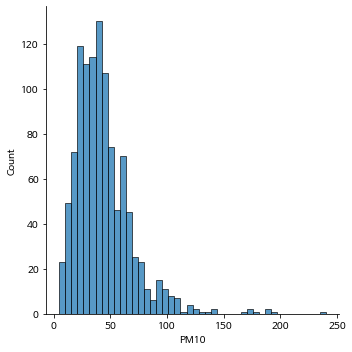

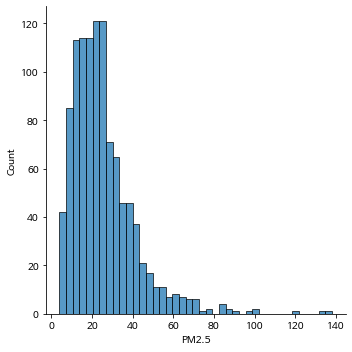

In [9]:
sns.displot(x='PM10', kind='hist', data=df_daymean)
sns.displot(x='PM2.5', kind='hist', data=df_daymean)
plt.show()

<Axes: >

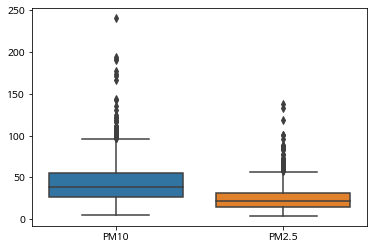

In [10]:
# 이상치 확인
sns.boxplot(data=df_daymean[['PM10', 'PM2.5']])

<Axes: >

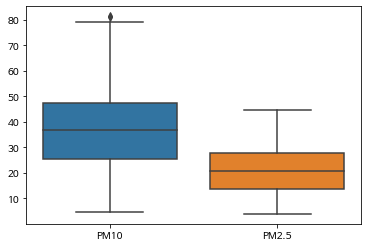

In [11]:
# 이상치 제거 함수
def remove_outliers(df, col_name):
    q1 = df[col_name].quantile(0.25) # 하위 25%
    q3 = df[col_name].quantile(0.75) # 상위 25%
    iqr = q3 - q1 # IQR 계산
    lower_bound = q1 - (1 * iqr) # 하한 값 계산
    upper_bound = q3 + (1 * iqr) # 상한 값 계산
    df = df[(df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)] # 이상치 제거
    return df

# PM10, PM2.5에 대한 이상치 제거
df_daymean = remove_outliers(df_daymean, 'PM10')
df_daymean = remove_outliers(df_daymean, 'PM2.5')

# boxplot으로 이상치 제거 결과 확인
sns.boxplot(data=df_daymean[['PM10', 'PM2.5']])

In [12]:
# 상관계수
df_air = df_daymean.corr()
df_air

<ipython-input-12-cafb24846520>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_air = df_daymean.corr()


,SO2,NO2,O3,CO,PM10,PM2.5
SO2,1.000000,0.880500,0.855932,0.263964,0.161528,0.125670
NO2,0.880500,1.000000,0.698836,0.558084,0.356869,0.340894
O3,0.855932,0.698836,1.000000,-0.011400,0.153230,0.105833
CO,0.263964,0.558084,-0.011400,1.000000,0.601016,0.646071
PM10,0.161528,0.356869,0.153230,0.601016,1.000000,0.808631
PM2.5,0.125670,0.340894,0.105833,0.646071,0.808631,1.000000


[]

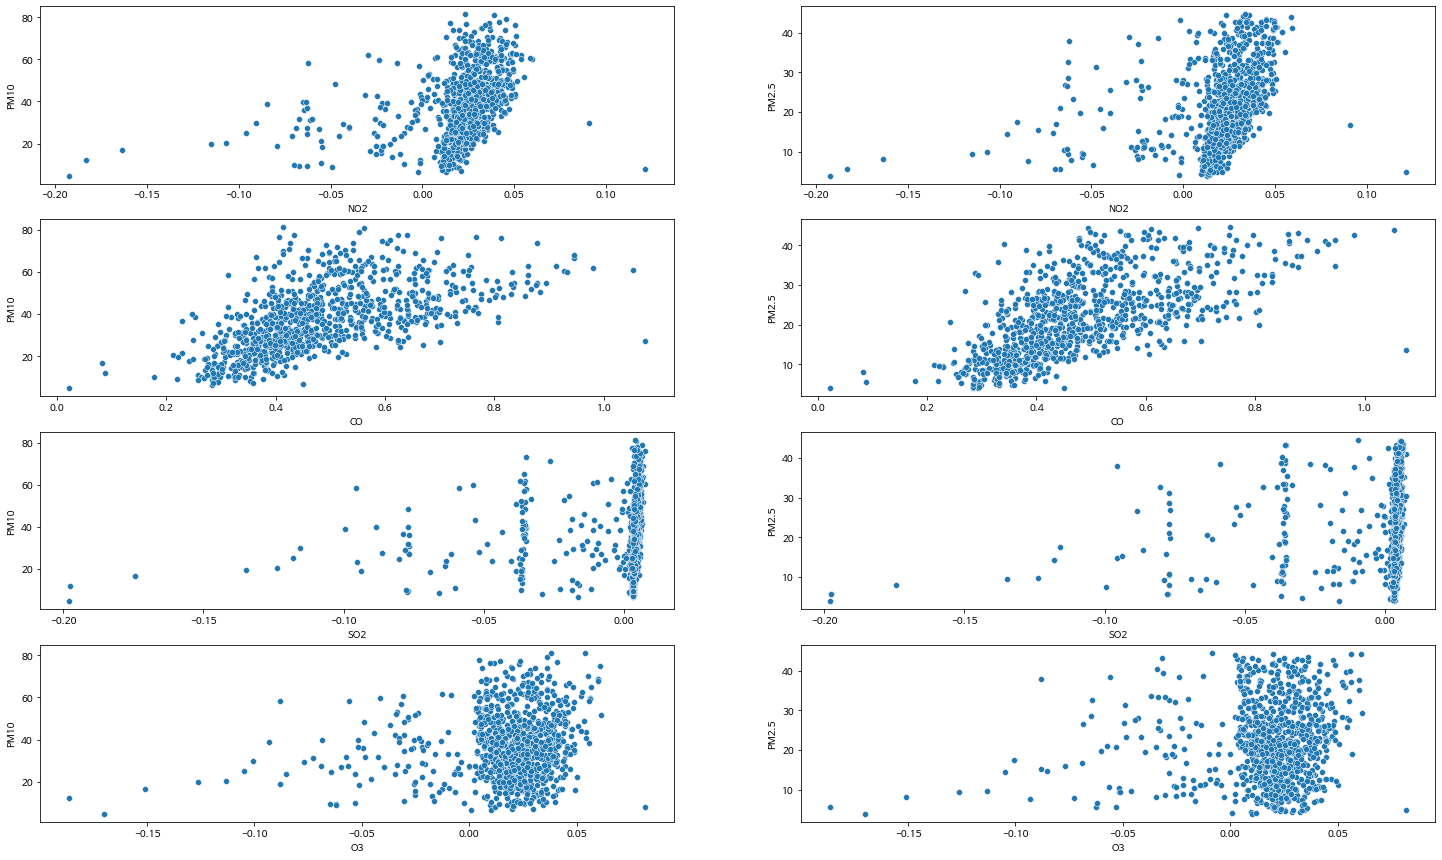

In [13]:
# 일간 평균으로 NO2, CO, SO2, O3과 PM10, PM2.5의 상관관계 시각화
f, ax = plt.subplots(4, 2, figsize=(25,15))
sns.scatterplot(x='NO2', y= 'PM10', data=df_daymean, ax=ax[0,0])
sns.scatterplot(x='NO2', y= 'PM2.5', data=df_daymean, ax=ax[0,1])
sns.scatterplot(x='CO', y= 'PM10', data=df_daymean, ax=ax[1,0])
sns.scatterplot(x='CO', y= 'PM2.5', data=df_daymean, ax=ax[1,1])
sns.scatterplot(x='SO2', y= 'PM10', data=df_daymean, ax=ax[2,0])
sns.scatterplot(x='SO2', y= 'PM2.5', data=df_daymean, ax=ax[2,1])
sns.scatterplot(x='O3', y= 'PM10', data=df_daymean, ax=ax[3,0])
sns.scatterplot(x='O3', y= 'PM2.5', data=df_daymean, ax=ax[3,1])
plt.plot()
# pm10, pm2.5는 서로 연관성이 높고 O3는 pm10, pm2.5에는 큰 영향이 보이지 않음. 하지만 S02와 N02에 영향을 미치는 것으로 보임

In [14]:
df_daymean
df_daymean.iloc[:,1:5] # 미세먼지, 초미세먼지를 제외한 오존, 아산황가스, 일산화탄소를 독립변수로 지정
df_daymean.iloc[:,5:] # 미세먼지, 초미세먼지를 종속변수로 지정
X = df_daymean.iloc[:,1:5]
y = df_daymean.iloc[:,5:]
print(X)
print(y)

           SO2       NO2        O3        CO
3     0.004122  0.048813  0.006918  0.878500
4     0.003122  0.033892  0.009725  0.656333
5     0.002792  0.033360  0.011063  0.528833
6     0.003355  0.047610  0.002950  0.876000
7     0.002745  0.030257  0.013413  0.588167
...        ...       ...       ...       ...
1080  0.003433  0.028083  0.018195  0.556500
1081  0.003710  0.043712  0.005945  0.677167
1082  0.003337  0.037145  0.008980  0.641333
1083  0.003272  0.031195  0.012347  0.628500
1084  0.002880  0.017532  0.020642  0.399333

[961 rows x 4 columns]
           PM10      PM2.5
3     54.966667  34.533333
4     36.246667  22.168333
5     21.075000  13.251667
6     53.936667  37.175000
7     31.158333  21.725000
...         ...        ...
1080  34.030000  24.853333
1081  42.831667  25.313333
1082  44.428333  27.306667
1083  38.031667  27.060000
1084  25.448333  14.786667

[961 rows x 2 columns]


In [15]:
# 모델 생성 및 학습
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)

print(X_train)
print(X_test)
print(y_train)
print(y_test)
print(type(y_train))

           SO2       NO2        O3        CO
593   0.003410  0.012063  0.030167  0.283833
735   0.005242  0.037468  0.006632  0.649000
1026  0.003417  0.027827  0.020785  0.558333
262   0.003793  0.019518  0.025278  0.343667
243   0.003620  0.021207  0.025813  0.398000
...        ...       ...       ...       ...
131   0.006325  0.036792  0.036270  0.603167
359   0.004463  0.021110  0.014838  0.407667
434   0.004490  0.028895  0.030233  0.495167
414   0.003773  0.044137  0.009082  0.742667
578   0.004182  0.022218  0.055552  0.446833

[768 rows x 4 columns]
           SO2       NO2        O3        CO
195   0.003675  0.020185  0.022100  0.350333
417   0.004085  0.033335  0.019387  0.570000
905   0.003749  0.018963  0.033471  0.416571
178   0.004595  0.025617  0.042110  0.459333
194   0.001248  0.023443  0.032247  0.473000
...        ...       ...       ...       ...
712   0.004542  0.032110  0.011070  0.536333
997  -0.077170 -0.067078 -0.057423  0.331000
1030  0.003640  0.025660  0.023

In [16]:
# 하이퍼 파라미터 결정
params = {
    'n_estimators':(100, 200, 300, 400, 500),
    'max_depth' : (6, 8, 10, 12, 14),
    'min_samples_leaf' : (6, 8, 10, 12, 14),
    'min_samples_split' : (6, 8, 10, 12, 14)
}
rf_run = RandomForestRegressor(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_run, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)
 

print('최적 하이퍼 파라미터:', grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 100}
최적 예측 정확도: 0.5420


In [21]:
# 최적 하이퍼 파라미터: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 100}
# 멀티 아웃풋, 랜덤 포레스트 모델 학습
model = MultiOutputRegressor(RandomForestRegressor(max_depth=10, min_samples_leaf=6, min_samples_split=6, n_estimators=100))
model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))
pred = model.predict(X_test)
print(X_test)
print(type(X_test))
print(X_test.iloc[0,:])

0.7612721235521492
0.5347579204954069
           SO2       NO2        O3        CO
195   0.003675  0.020185  0.022100  0.350333
417   0.004085  0.033335  0.019387  0.570000
905   0.003749  0.018963  0.033471  0.416571
178   0.004595  0.025617  0.042110  0.459333
194   0.001248  0.023443  0.032247  0.473000
...        ...       ...       ...       ...
712   0.004542  0.032110  0.011070  0.536333
997  -0.077170 -0.067078 -0.057423  0.331000
1030  0.003640  0.025660  0.023672  0.515500
693   0.004655  0.040175  0.006543  0.680833
1057  0.004062  0.033397  0.013228  0.533167

[193 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
SO2    0.003675
NO2    0.020185
O3     0.022100
CO     0.350333
Name: 195, dtype: float64


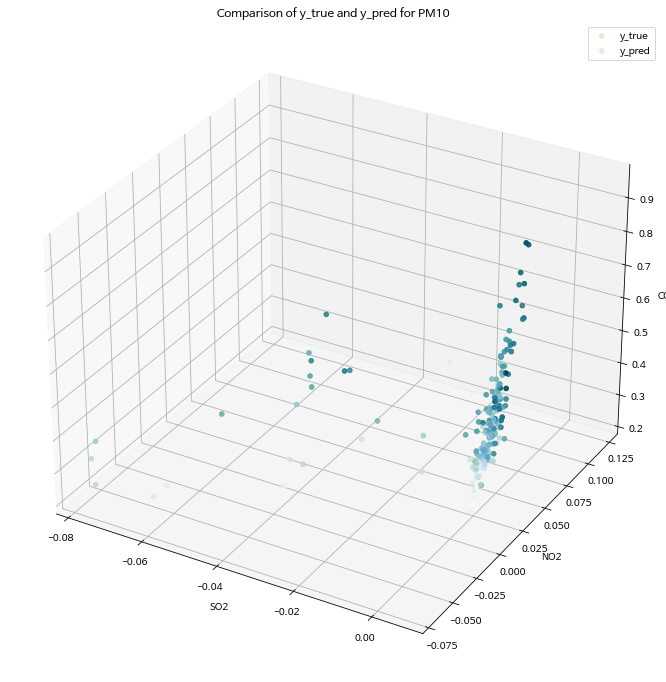

In [53]:
# 예측값과 실제값의 분포 시각화
# PM10과 PM2.5에 직접적인 영향이 미비한 O3 제외한 3차원 그래프
# PM10 시각화
y_true_pm10 = y_test['PM10']
y_pred = pd.DataFrame(data=pred, columns=['PM10', 'PM2.5'])
# print(y_pred)
# print(pred)
y_pred_pm10 = y_pred['PM10']

# 3차원 그래프 생성
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# X 변수 값들
x = X_test['SO2']
y = X_test['NO2']
z = X_test['CO']

# y_true와 y_pred의 값을 color로 설정하여 scatter plot 생성
ax.scatter(x, y, z, c=y_true_pm10, cmap='Greens', label='y_true')
ax.scatter(x, y, z, c=y_pred_pm10, cmap='Blues', alpha=0.5, label='y_pred')

# 그래프 축과 제목 설정
ax.set_xlabel('SO2')
ax.set_ylabel('NO2')
ax.set_zlabel('CO')
plt.title('Comparison of y_true and y_pred for PM10')
plt.legend()
plt.show()

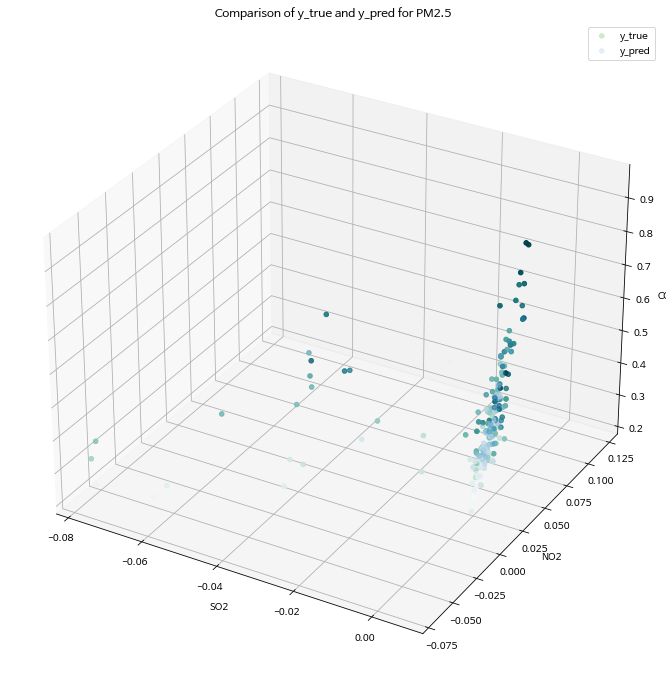

In [54]:
y_true_hpm = y_test['PM2.5']
y_pred_hpm = y_pred['PM2.5']

# 3차원 그래프 생성
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# X 변수 값들
x = X_test['SO2']
y = X_test['NO2']
z = X_test['CO']

# y_true와 y_pred의 값을 color로 설정하여 scatter plot 생성
ax.scatter(x, y, z, c=y_true_hpm, cmap='Greens', label='y_true')
ax.scatter(x, y, z, c=y_pred_hpm, cmap='Blues', alpha=0.5, label='y_pred')

# 그래프 축과 제목 설정
ax.set_xlabel('SO2')
ax.set_ylabel('NO2')
ax.set_zlabel('CO')
plt.title('Comparison of y_true and y_pred for PM2.5')
plt.legend()
plt.show()

In [42]:
y_test

,PM10,PM2.5
195,20.593333,13.850000
417,45.170000,27.241667
905,33.302857,24.977143
178,47.896667,31.586667
194,47.135000,33.313333
...,...,...
712,37.200000,20.920000
997,31.746667,21.093333
1030,62.018333,27.705000
693,47.955000,34.243333


In [22]:
# 모델 성능 평가
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# 결정계수(R2 score)
print('R2 :',r2_score(y_test, pred))

# MSE
mse = mean_squared_error(y_test, pred)
print('MSE :', mse)

# RMSE
print('RMSE :',np.sqrt(mse))

# MAE
mae = mean_absolute_error(y_test, pred)
print('MAE :', mae)

R2 : 0.5347579204954069
MSE : 76.5614924987168
RMSE : 8.749942428308703
MAE : 6.573621122388699


In [24]:
# 23.03.24 서울시의 데이터   SO2 0.003 NO2 0.037 O3 0.032 CO 0.5
# 초미세먼지	PM-2.5	27㎍/㎥	보통
# 미세먼지	PM-10	124㎍/㎥	나쁨
# 오존	O₃	0.032ppm	보통
# 이산화질소	NO₂	0.037ppm	보통
# 일산화탄소	CO	0.5ppm	좋음
# 아황산가스	SO₂	0.003ppm	좋음
# 0.003627  0.044765  0.002478  0.981833
print(model.predict([[0.003627, 0.044765, 0.002478, 0.981833]])) # 실제 값 77.201667  56.773333
print(model.predict([[0.003, 0.037, 0.032, 0.5]])) # 실제 값 124, 27

[[47.84109158 33.31961639]]
[[52.27463098 32.44944688]]


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
